# Test Different Interpolation Methods for Interpolated Reads

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import math
from scipy.io import wavfile

In [130]:
# Compute distance from microphone to line

# Straight Trajectory between starting and end point
P1 = np.array([3,20])
P2 = np.array([3, -5])
P3 = np.array([0,0])

v = 5   # speed of sound source
fs = 8000

# Compute distance from MIC (origin) to line
dline = np.abs((P2[0] - P1[0]) * (P1[1] - P3[1]) - (P1[0] - P3[0]) * (P2[1] - P1[1])) / np.sqrt(np.sum((P2-P1)**2))
dline2 = dline ** 2
# What happens when the line is exactly on the x or y axes?

# Compute distance from P0 to projection of MIC on the line
l2 = np.sum((P1-P2)**2)
t = np.sum((P3 - P1) * (P2 - P1)) / l2
P_proj = P1 + t * (P2 - P1)
dproj = np.sqrt(np.sum((P1 - P_proj) ** 2))

# Compute initial distance from MIC to P1
dinit = np.sqrt(dproj ** 2 + dline ** 2)

# Compute time delay in number of samples
c = 343
tau_init = dinit / c

M_init = tau_init * fs
print(M_init)

delays_sec = []
delays_smp = []
delays_sec.append(tau_init)

# Define delay line
N = 1024
A = np.zeros(N)

# Windowed Sinc Function
sinc_samples = 81
sinc_window = np.hanning(sinc_samples)


rptr = 0
wptr = 0
M = np.floor(M_init)    # Define initial delay
delays_smp.append(M)
# print(d)
def set_delay(M):
    global rptr
    rptr = wptr - M
    if (rptr < 0):
        rptr += N

def frac_delay_sinc(delay):
    global sinc_samples
    global sinc_window

    return sinc_window * np.sinc(np.arange(0,sinc_samples) - (sinc_samples - 1) / 2 - delay)

def frac_delay_lagrange(N, delay):
    n = np.arange(0,N+1)
    h = np.ones(N+1)

    for k in range(0,N+1):
        # Find index n != k
        index = []
        for j in range(0,N+1):
            if j != k:
                index.append(j)
        
        h[index] = h[index] * (delay - k) / (n[index] - k)

    return h

def delay_line(x):
    global rptr
    global wptr
    global A
    global v
    global dproj
    global c
    global fs
    global delays_smp
    
    A[wptr] = x
    wptr += 1

    rpi = math.floor(rptr)
    a = rptr - rpi
    # Linear Interpolation
    y1 = a * A[rpi + 1] + (1 - a) * A[rpi]
    
    # Sinc Interpolation -> Windowed Sinc function
    h_sinc = frac_delay_sinc(a)
    
    y2 = 0
    for i in range(0, sinc_samples):
        y2 = y2 + h_sinc[i]*A[np.mod(rpi + i - math.floor(sinc_samples/2), len(A))]
    
    # Lagrange Interpolation
    order = 9
    h_lagrange = frac_delay_lagrange(order, a)
    y3 = 0

    for i in range(0, len(h_lagrange)):
        y3 = y3 + h_lagrange[i] * A[np.mod(rpi + i, len(A))]

    # Update delay
    dproj -= v / fs
    
    d = dline2 + dproj ** 2 
    tau = np.sqrt(d) / c
    M = tau * fs
    rptr = wptr - M

    # For the plots, remove later
    delays_sec.append(tau)
    delays_smp.append(M)

    if (rptr < 0):
        rptr += N
    if (wptr >= N - 1):
        wptr -= (N)
    if (rptr >= N - 1):
        rptr -= (N)
    return y1, y2, y3, d

set_delay(M)
a = 0
signal = 0
## Test with signal
fs = 8000
f = 2200

time = np.arange(0, 6, 1/fs)

# Sinusoidal
signal = np.sin(2 * np.pi * f * time)

# Noise
# signal = np.random.randn(len(time))

# Train impulse
# signal = np.zeros_like(time)
# signal[::500] = 1

aa = np.zeros_like(signal)
bb = np.zeros_like(signal)
cc = np.zeros_like(signal)
for i in range(0, len(signal)):
    [sample1, sample2, sample3, d] = delay_line(signal[i])
    attenuation = 1 # / (4 * np.pi * d)
    # attenuation = 1
    aa[i] = attenuation * sample1
    bb[i] = attenuation * sample2
    cc[i] = attenuation * sample3
    # a[i] = delay_line(signal[i])

471.6909251581734


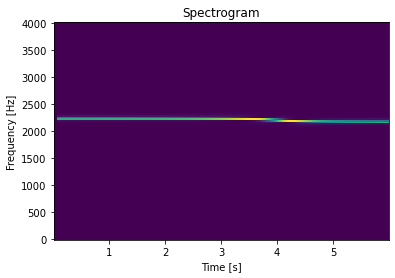

Text(0.5, 1.0, 'FFT Lagrange Interpolated Signal')

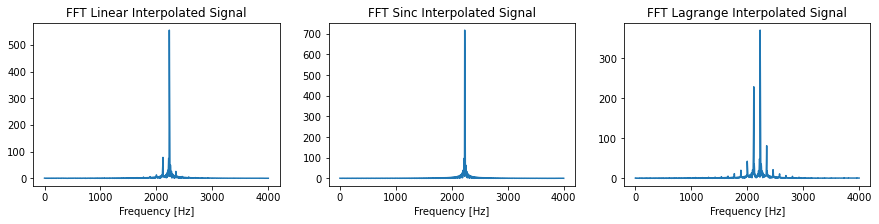

In [131]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import signal as sig

ff, tt, Sxx = sig.spectrogram(bb, fs)
# plt.subplot(2,1,1)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')
plt.title('Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
# plt.subplot(2,1,2)
# plt.plot(range(0, 2048), a[1024:1024+2048])
plt.show()

wavfile.write('prova.wav', fs, 0.2*cc)

# FFT of signals
Nfft = 2048
f_axis = np.linspace(0, fs / 2, int(Nfft / 2 + 1))
fft_aa = np.fft.fft(aa, Nfft)
fft_bb = np.fft.fft(bb, Nfft)
fft_cc = np.fft.fft(cc, Nfft)

fig, axes = plt.subplots(1,3, figsize = (15, 3))
axes[0].plot(f_axis, abs(fft_aa[:int(Nfft/2 + 1)]))
axes[0].set_xlabel('Frequency [Hz]')
axes[0].set_title('FFT Linear Interpolated Signal')

axes[1].plot(f_axis, abs(fft_bb[:int(Nfft/2 + 1)]))
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_title('FFT Sinc Interpolated Signal')

axes[2].plot(f_axis, abs(fft_cc[:int(Nfft/2 + 1)]))
axes[2].set_xlabel('Frequency [Hz]')
axes[2].set_title('FFT Lagrange Interpolated Signal')